### Import Libraries

In [1]:
import pandas as pd
import numpy as np

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# !pwd

### Setup MLFlow

Create local aritfact store:
```bash
mkdir -p $(pwd)/../mlruns_artifacts
```

Using UI : 
```bash 
mlflow ui --backend-store-uri sqlite:///mlflow.db
```

Using server : 
```bash
mlflow server \
--backend-store-uri sqlite:///mlflow.db \
--default-artifact-root file:///$(pwd)/../mlruns_artifacts 
``` 


In [3]:
import mlflow

# mlflow.set_tracking_uri("sqlite:///mlflow.db") # UI tracking
mlflow.set_tracking_uri("http://127.0.0.1:5000") # server tracking

print(f"Tracking URI: '{mlflow.get_tracking_uri()}'")
mlflow.set_experiment("airbnb-experiment")
mlflow.autolog(disable=True)

Tracking URI: 'http://127.0.0.1:5000'


2024/11/25 02:40:48 INFO mlflow.tracking.fluent: Experiment with name 'airbnb-experiment' does not exist. Creating a new experiment.


In [4]:
mlflow.search_experiments()

[<Experiment: artifact_location='file:////home/oliver/Desktop/Workspace/Projects/airbnb-price-prediciton/experiment-tracking/../mlruns_artifacts/1', creation_time=1732477248929, experiment_id='1', last_update_time=1732477248929, lifecycle_stage='active', name='airbnb-experiment', tags={}>,
 <Experiment: artifact_location='file:////home/oliver/Desktop/Workspace/Projects/airbnb-price-prediciton/experiment-tracking/../mlruns_artifacts/0', creation_time=1732477234398, experiment_id='0', last_update_time=1732477234398, lifecycle_stage='active', name='Default', tags={}>]

### Load Data

In [5]:
def read_dataframe(filename):
    df = pd.read_csv(filename)
    
    # Handle missing values
    df = df.dropna(subset=['price'])
    df['reviews_per_month'] = df['reviews_per_month'].fillna(0)
    df['last_review'] = pd.to_datetime(df['last_review'])
    
    # Apply a log10 transformation to the target column
    df['price'] = np.log10(df['price'])

    return df

In [6]:
def preprocess(df):
    # Calculate IQR
    Q1 = df['price'].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df['price'].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range

    # Define outlier boundaries
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Remove outliers
    df = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)].reset_index(drop=True)
    
    return df

In [7]:
df_train = read_dataframe("../datasets/airbnb-listings-may.csv")
df_val = read_dataframe("../datasets/airbnb-listings-june.csv")

In [8]:
df_train = preprocess(df_train)
df_val = preprocess(df_val)

In [9]:
len(df_train), len(df_val)

(328, 357)

In [10]:
# Feature selection
numerical = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'availability_365']
categorical = ['room_type', 'neighbourhood']

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

# dv = DictVectorizer()
# X_train = dv.fit_transform(train_dicts)
# X_val = dv.transform(val_dicts)

In [11]:
target = "price"
y_train = df_train[target].values
y_val = df_val[target].values

### LinearRegression

In [12]:
# Create a pipeline with DictVectorizer and LinearRegression
pipeline = Pipeline([
    ('dv', DictVectorizer()),
    ('lr', LinearRegression())
])

pipeline.fit(train_dicts, y_train)
y_pred = pipeline.predict(val_dicts)
rmse = root_mean_squared_error(y_val, y_pred)
print("RMSE: ", rmse)

RMSE:  0.16307290098131869


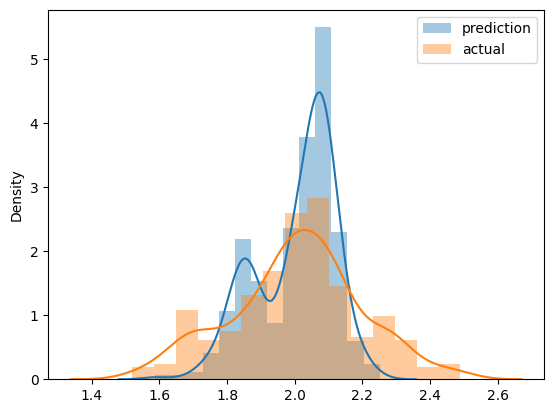

In [13]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()
plt.show()

In [14]:
from mlflow.models import infer_signature

signature = infer_signature(val_dicts, y_val)
signature

inputs: 
  ['room_type': string (required), 'neighbourhood': string (required), 'latitude': double (required), 'longitude': double (required), 'minimum_nights': long (required), 'number_of_reviews': long (required), 'reviews_per_month': double (required), 'availability_365': long (required)]
outputs: 
  [Tensor('float64', (-1,))]
params: 
  None

In [15]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run():

    mlflow.set_tag("developer", "oliver")
    mlflow.log_param("train-data-path", "../datasets/airbnb-listings-may.csv")
    mlflow.log_param("val-data-path", "../datasets/airbnb-listings-june.csv")
    mlflow.log_param("model_name", "Linear Regression")  # Log model name
    
    pipeline = Pipeline([
        ('dv', DictVectorizer()),
        ('lr', LinearRegression())
    ])

    pipeline.fit(train_dicts, y_train)
    y_pred = pipeline.predict(val_dicts)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
    
    # with open("../models/preprocessor.b", "wb") as f_out:
    #     pickle.dump(dv, f_out)
    # mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

    # with open("../models/lin_reg.bin", "wb") as f_out:
    #     pickle.dump(pipeline, f_out)
    # mlflow.log_artifact(local_path="../models/lin_reg.bin", artifact_path="model")
    
    # Log the trained pipeline as a model
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="model",
        signature=signature
    )

🏃 View run trusting-elk-226 at: http://127.0.0.1:5000/#/experiments/1/runs/057344a524bf4384ab2545c94a92d926
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### LASSO

In [16]:
mlflow.sklearn.autolog(disable=True)

with mlflow.start_run():

    mlflow.set_tag("developer", "oliver")
    mlflow.log_param("train-data-path", "../datasets/airbnb-listings-may.csv")
    mlflow.log_param("val-data-path", "../datasets/airbnb-listings-june.csv")
    mlflow.log_param("model_name", "Lasso")  # Log model name
    
    params = {
        'alpha': 0.1,
    }
    mlflow.log_params(params)
    
    pipeline = Pipeline([
        ('dv', DictVectorizer()),
        ('lr', Lasso(**params))
    ])

    pipeline.fit(train_dicts, y_train)
    y_pred = pipeline.predict(val_dicts)
    
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)
    
    # with open("../models/preprocessor.b", "wb") as f_out:
    #     pickle.dump(dv, f_out)
    # mlflow.log_artifact("../models/preprocessor.b", artifact_path="preprocessor")

    # with open("../models/lasso_reg.bin", "wb") as f_out:
    #     pickle.dump(pipeline, f_out)
    # mlflow.log_artifact(local_path="../models/lasso_reg.bin", artifact_path="model")
    # Log the trained pipeline as a model
    
    mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="model",
        signature=signature
    )

🏃 View run adaptable-midge-920 at: http://127.0.0.1:5000/#/experiments/1/runs/80df4ccb73894bb8968c34e9b358f675
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### XGBoost

In [17]:
# !pip install hyperopt

In [18]:
import xgboost as xgb
from xgboost import XGBRegressor

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [19]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [20]:


# def objective(params):
#     with mlflow.start_run():
#         mlflow.set_tag("model", "xgboost")
#         mlflow.log_params(params)
#         booster = xgb.train(
#             params=params,
#             dtrain=train,
#             num_boost_round=1000,
#             evals=[(valid, 'validation')],
#             early_stopping_rounds=50
#         )
#         y_pred = booster.predict(valid)
#         rmse = root_mean_squared_error(y_val, y_pred)
#         mlflow.log_metric("rmse", rmse)

#     return {'loss': rmse, 'status': STATUS_OK}

def objective(params):
    booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    return {'loss': rmse, 'status': STATUS_OK}

In [21]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=2,
    trials=Trials()
)

print("Best params: ", best_result)

[0]	validation-rmse:0.17560                          
[1]	validation-rmse:0.16569                          
[2]	validation-rmse:0.15946                          
[3]	validation-rmse:0.15523                          
[4]	validation-rmse:0.14941                          
[5]	validation-rmse:0.14562                          
[6]	validation-rmse:0.14298                          
[7]	validation-rmse:0.14002                          
[8]	validation-rmse:0.13768                          
[9]	validation-rmse:0.13523                          
[10]	validation-rmse:0.13334                         
[11]	validation-rmse:0.13157                         
[12]	validation-rmse:0.13004                         
[13]	validation-rmse:0.12963                         
[14]	validation-rmse:0.12865                         
[15]	validation-rmse:0.12735                         
[16]	validation-rmse:0.12642                         
[17]	validation-rmse:0.12519                         
[18]	validation-rmse:0.12458

In [22]:
# Using Pipeline
best_params = {
        **best_result,
        "random_state" : 42
    }

pipeline = Pipeline([
    ('dv', DictVectorizer()),
    ('regressor', XGBRegressor(**params))
])
    
pipeline.fit(train_dicts, y_train)
y_pred = pipeline.predict(val_dicts)

rmse = root_mean_squared_error(y_val, y_pred)
print("RMSE: ", rmse)

RMSE:  0.09902075254547381


In [23]:
mlflow.xgboost.autolog(disable=True)

with mlflow.start_run():
    
    mlflow.set_tag("developer", "oliver")
    mlflow.log_param("train-data-path", "../datasets/airbnb-listings-may.csv")
    mlflow.log_param("val-data-path", "../datasets/airbnb-listings-june.csv")
   
    best_params = {
        **best_result,
        "random_state" : 42
    }

    mlflow.log_params(best_params)
    pipeline = Pipeline([
        ('dv', DictVectorizer()),
        ('regressor', XGBRegressor(**params))
    ])
        
    pipeline.fit(train_dicts, y_train)
    y_pred = pipeline.predict(val_dicts)
    
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.sklearn.log_model(
        pipeline, 
        artifact_path="model",
        signature=signature
        )

🏃 View run spiffy-rook-997 at: http://127.0.0.1:5000/#/experiments/1/runs/1936d050006746eeaa60c76db167d18c
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### Other

In [24]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

# Using mlflow autolog
mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.set_tag("developer", "oliver")
        mlflow.log_param("train-data-path", "../datasets/airbnb-listings-may.csv")
        mlflow.log_param("val-data-path", "../datasets/airbnb-listings-june.csv")
   
        mlmodel = model_class()
        
        pipeline = Pipeline([
            ('dv', DictVectorizer()),
            ('model', mlmodel)
            ])

        pipeline.fit(train_dicts, y_train)
        y_pred = pipeline.predict(val_dicts)
        
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)
        
        mlflow.sklearn.log_model(
            sk_model=pipeline,
            artifact_path="model",
            signature=signature
        )

2024/11/25 02:41:06 WARNING mlflow.sklearn: Unrecognized dataset type <class 'list'>. Dataset logging skipped.
2024/11/25 02:41:09 WARNING mlflow.sklearn: Unrecognized dataset type <class 'list'>. Dataset logging skipped.
2024/11/25 02:41:10 WARNING mlflow.sklearn: Unrecognized dataset type <class 'list'>. Dataset logging skipped.


🏃 View run gregarious-stoat-586 at: http://127.0.0.1:5000/#/experiments/1/runs/ea8e1bad8e904043b3f72806f4c607e0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


2024/11/25 02:41:12 WARNING mlflow.sklearn: Unrecognized dataset type <class 'list'>. Dataset logging skipped.
2024/11/25 02:41:14 WARNING mlflow.sklearn: Unrecognized dataset type <class 'list'>. Dataset logging skipped.


🏃 View run bold-ape-691 at: http://127.0.0.1:5000/#/experiments/1/runs/1002a060f4f949f38fb6ec0c47def5b2
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


2024/11/25 02:41:16 WARNING mlflow.sklearn: Unrecognized dataset type <class 'list'>. Dataset logging skipped.
2024/11/25 02:41:18 WARNING mlflow.sklearn: Unrecognized dataset type <class 'list'>. Dataset logging skipped.


🏃 View run upbeat-yak-606 at: http://127.0.0.1:5000/#/experiments/1/runs/bfddb2a46955440ead9813cfc19ba2ec
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


2024/11/25 02:41:20 WARNING mlflow.sklearn: Unrecognized dataset type <class 'list'>. Dataset logging skipped.


🏃 View run monumental-hog-824 at: http://127.0.0.1:5000/#/experiments/1/runs/48369b0c128743fd9040a7c6ef943cb4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


### Load models

In [43]:
input_data = {
        "room_type": "Entire home/apt",
        "neighbourhood": "SIXTH WARD",
        "latitude": 42.65222,
        "longitude": -73.76724,
        "minimum_nights": 2,
        "number_of_reviews": 302,
        "reviews_per_month": 2.53,
        "availability_365": 253
    }

pd.DataFrame([input_data])

,room_type,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,availability_365
0,Entire home/apt,SIXTH WARD,42.65222,-73.76724,2,302,2.53,253


In [47]:
# XGBoost
RUN_ID = '1936d050006746eeaa60c76db167d18c'
logged_model = f'runs:/{RUN_ID}/model'

# Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)
loaded_model = mlflow.sklearn.load_model(logged_model)
loaded_model


Pipeline(steps=[('dv', DictVectorizer()),
                ('regressor',
                 XGBRegressor(alpha=0.1, base_score=None, booster=None,
                              callbacks=None, colsample_bylevel=None,
                              colsample_bynode=None, colsample_bytree=None,
                              device=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [50]:
y_pred = loaded_model.predict(val_dicts)
rmse = root_mean_squared_error(y_val, y_pred)
print("RMSE: ", rmse)

RMSE:  0.09902075254547381


In [52]:
## Linear Regression
RUN_ID = '057344a524bf4384ab2545c94a92d926'
logged_model = f'runs:/{RUN_ID}/model'

# Load model.
loaded_model = mlflow.sklearn.load_model(logged_model)
loaded_model


Pipeline(steps=[('dv', DictVectorizer()), ('lr', LinearRegression())])

In [53]:
y_pred = loaded_model.predict(val_dicts)
rmse = root_mean_squared_error(y_val, y_pred)
print("RMSE: ", rmse)

RMSE:  0.16307290098131869
